## Percobaan 2

Ekualisasi, Median, Gauss

In [11]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

In [12]:
from collections import defaultdict

data = []
labels = []
file_name = []
max_per_label = 70
label_counter = defaultdict(int)

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for filename in sub_folder_files:
        if label_counter[sub_folder] >= max_per_label:
            continue
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        if img is not None:
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  # Konversi ke grayscale
            img = cv.resize(img, (128, 128))           # Resize ke ukuran tetap
            img = img.astype(np.uint8)                 # Tipe data sesuai

            data.append(img)
            labels.append(sub_folder)
            file_name.append(filename)
            label_counter[sub_folder] += 1

data = np.array(data)
labels = np.array(labels)


## Data Augmentation

### Define Augmentation Function

In [13]:
def augment_image(img):
    augmented = [img]
    # Flip horizontal
    # Flip horizontal (manual)
    flip_h = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            flip_h[i, j] = img[i, img.shape[1] - 1 - j]
    augmented.append(flip_h)

    # Flip vertical (manual)
    flip_v = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            flip_v[i, j] = img[img.shape[0] - 1 - i, j]
    augmented.append(flip_v)

    # Rotate 90 degrees (manual, counter-clockwise)
    rot90 = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            rot90[j, img.shape[0] - 1 - i] = img[i, j]
    augmented.append(rot90)

    # Rotate 180 degrees (manual)
    rot180 = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            rot180[img.shape[0] - 1 - i, img.shape[1] - 1 - j] = img[i, j]
    augmented.append(rot180)
    return augmented

In [14]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	augmented_imgs = augment_image(data[i])
	for aug_img in augmented_imgs:
		data_augmented.append(aug_img)
		labels_augmented.append(labels[i])
		file_name_augmented.append(file_name[i])

In [15]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  490
Data setelah augmentasi:  2450


## Data Preparation

### Define Preprocessing

In [16]:
def histogram_equalization(img_gray):
    hist, bins = np.histogram(img_gray.flatten(), bins=256, range=[0,255])
    cdf = hist.cumsum()
    cdf_normalized = cdf * 255 / cdf[-1]
    img_eq = np.interp(img_gray.flatten(), bins[:-1], cdf_normalized)
    return img_eq.reshape(img_gray.shape).astype(np.uint8)

def median(arr):
    n = len(arr)
    sorted_arr = sorted(arr)
    if n % 2 == 0:
        median1 = sorted_arr[n//2]
        median2 = sorted_arr[n//2 - 1]
        median = (median1 + median2)/2
    else:
        median = sorted_arr[n//2]
        
    return median

def filter_median(image, kernel):
    # mengambil nilai shape dari variabel image dan kernel 
    heightImage, widthImage = image.shape
    heightKernel, widthKernel = kernel.shape
    # melakukan perhitungan untuk mencari nilai tengah 
    heigthCenter = int((heightKernel - 1)/2)
    widthCenter = int((widthKernel - 1)/2)

    # proses padding 
    leftPad = widthCenter
    rightPad = widthKernel - widthCenter
    topPad = heigthCenter
    botPad = heightKernel - heigthCenter
    image = np.pad(image, ((leftPad, rightPad), (topPad, botPad)), mode='edge')

    result = np.zeros([heightImage, widthImage])
    # proses konvolusi
    for i in range(heightImage):
         for j in range(widthImage):
             temp = np.zeros(len(kernel)*len(kernel))
             indeks = 0
             for k in range(heightKernel):
                 for l in range(widthKernel):
                     temp[indeks] += image[i+k,j+l]
                     indeks+=1
                     result[i,j] = median(temp)
             
    return np.clip(result, 0, 255).astype(np.uint8)

def filter_image(image, kernel):
    HtoInt = int((kernel.shape[0] - 1) / 2)
    WtoInt = int((kernel.shape[1] - 1) / 2)
    PaddingKanan = kernel.shape[1] - WtoInt
    PaddingBawah = kernel.shape[0] - HtoInt
    result = np.zeros(image.shape)
    imgs = np.pad(image, ((HtoInt, PaddingBawah), (WtoInt, PaddingKanan)), mode='edge')
    
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            pixel = 0
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    pixel += imgs[i + k, j + l] * kernel[k, l]
            result[i, j] = pixel
            
    return result

## Preprocessing

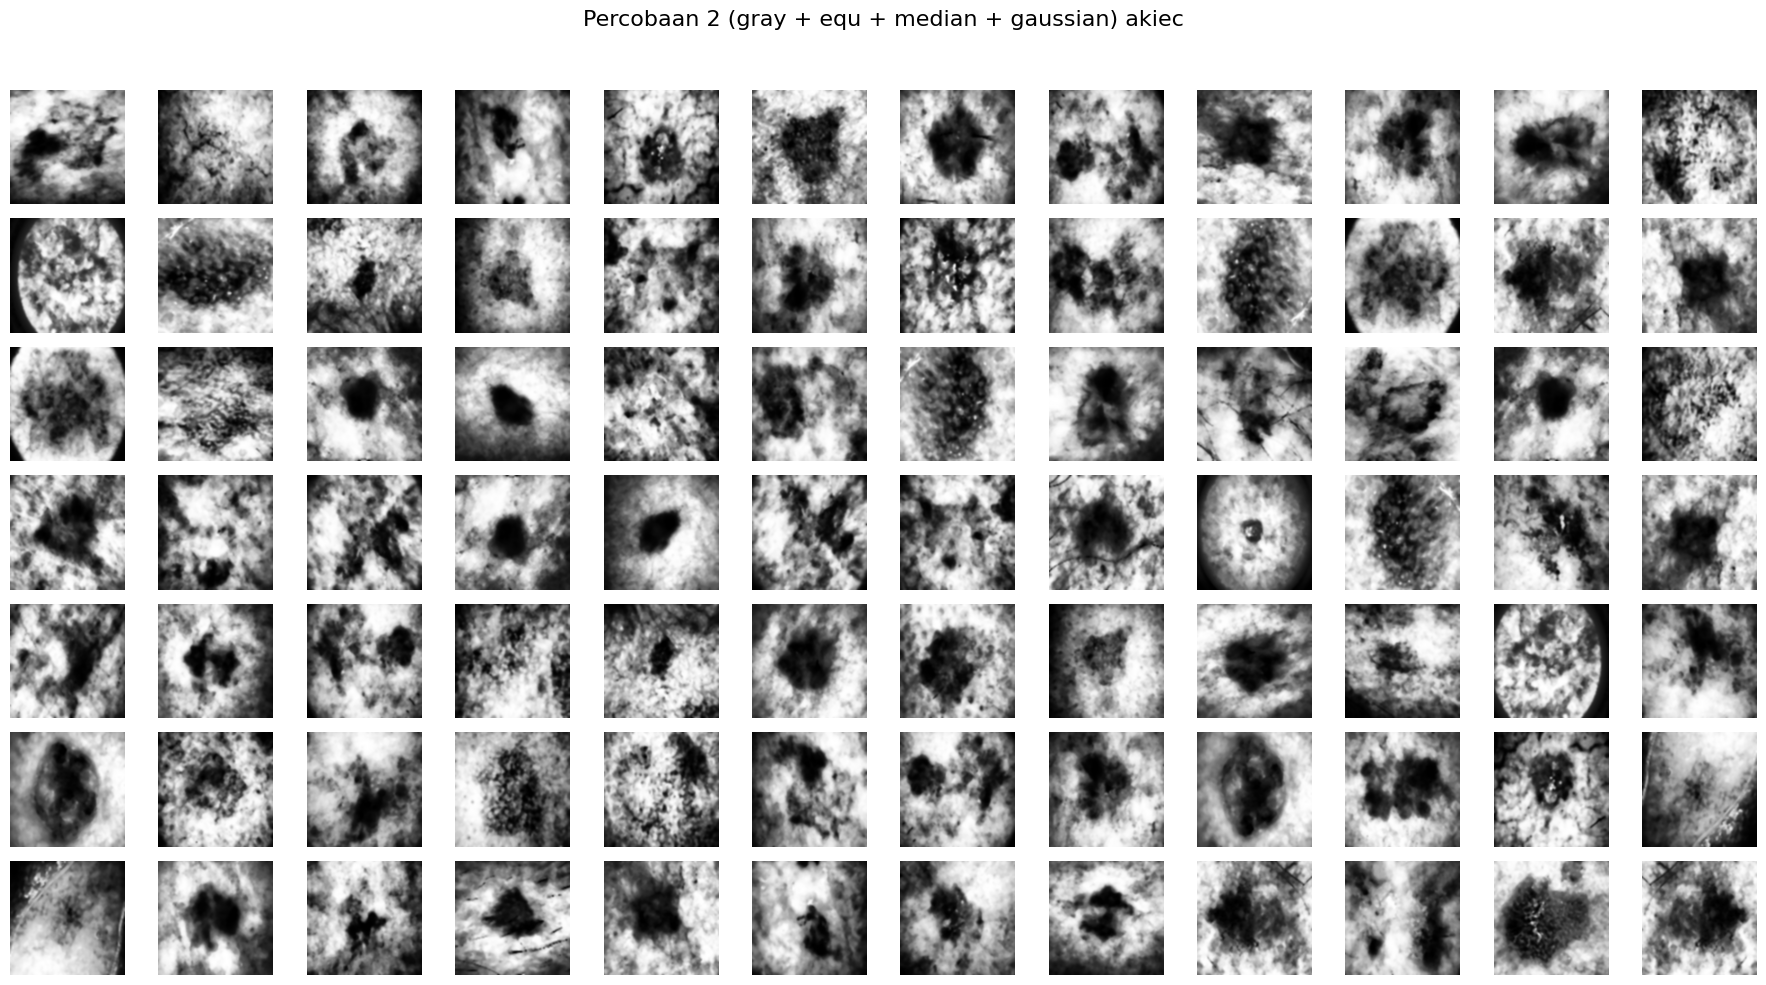

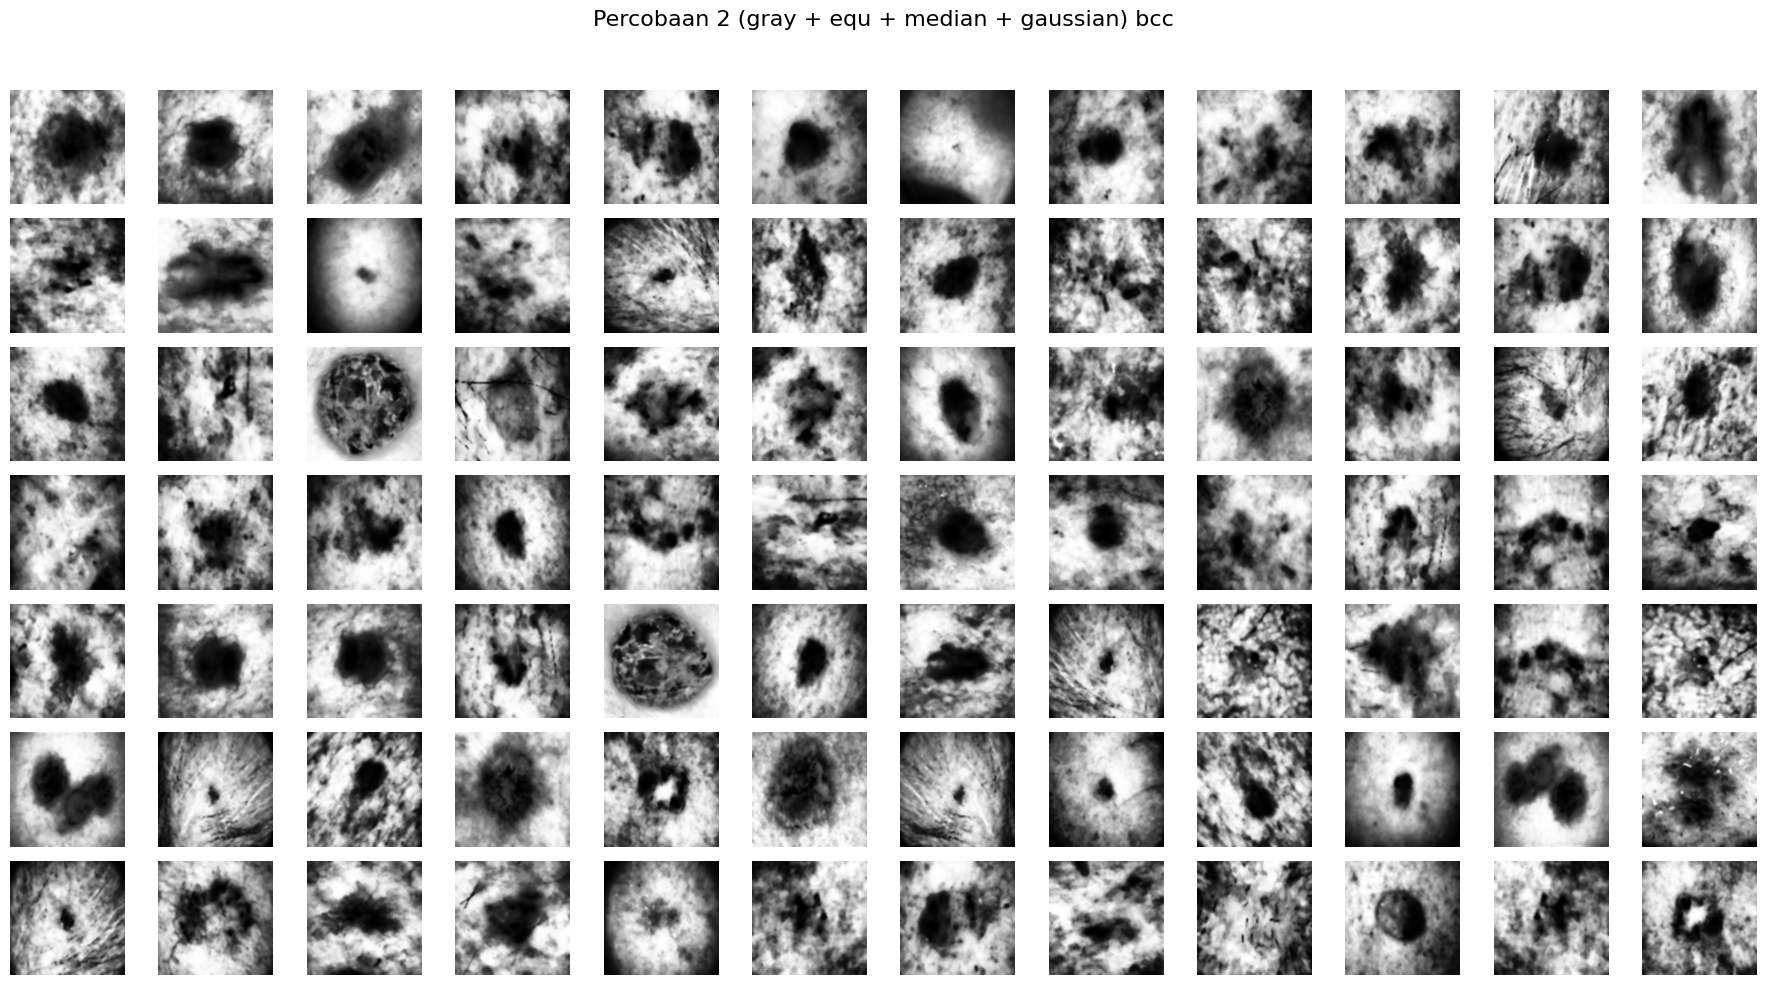

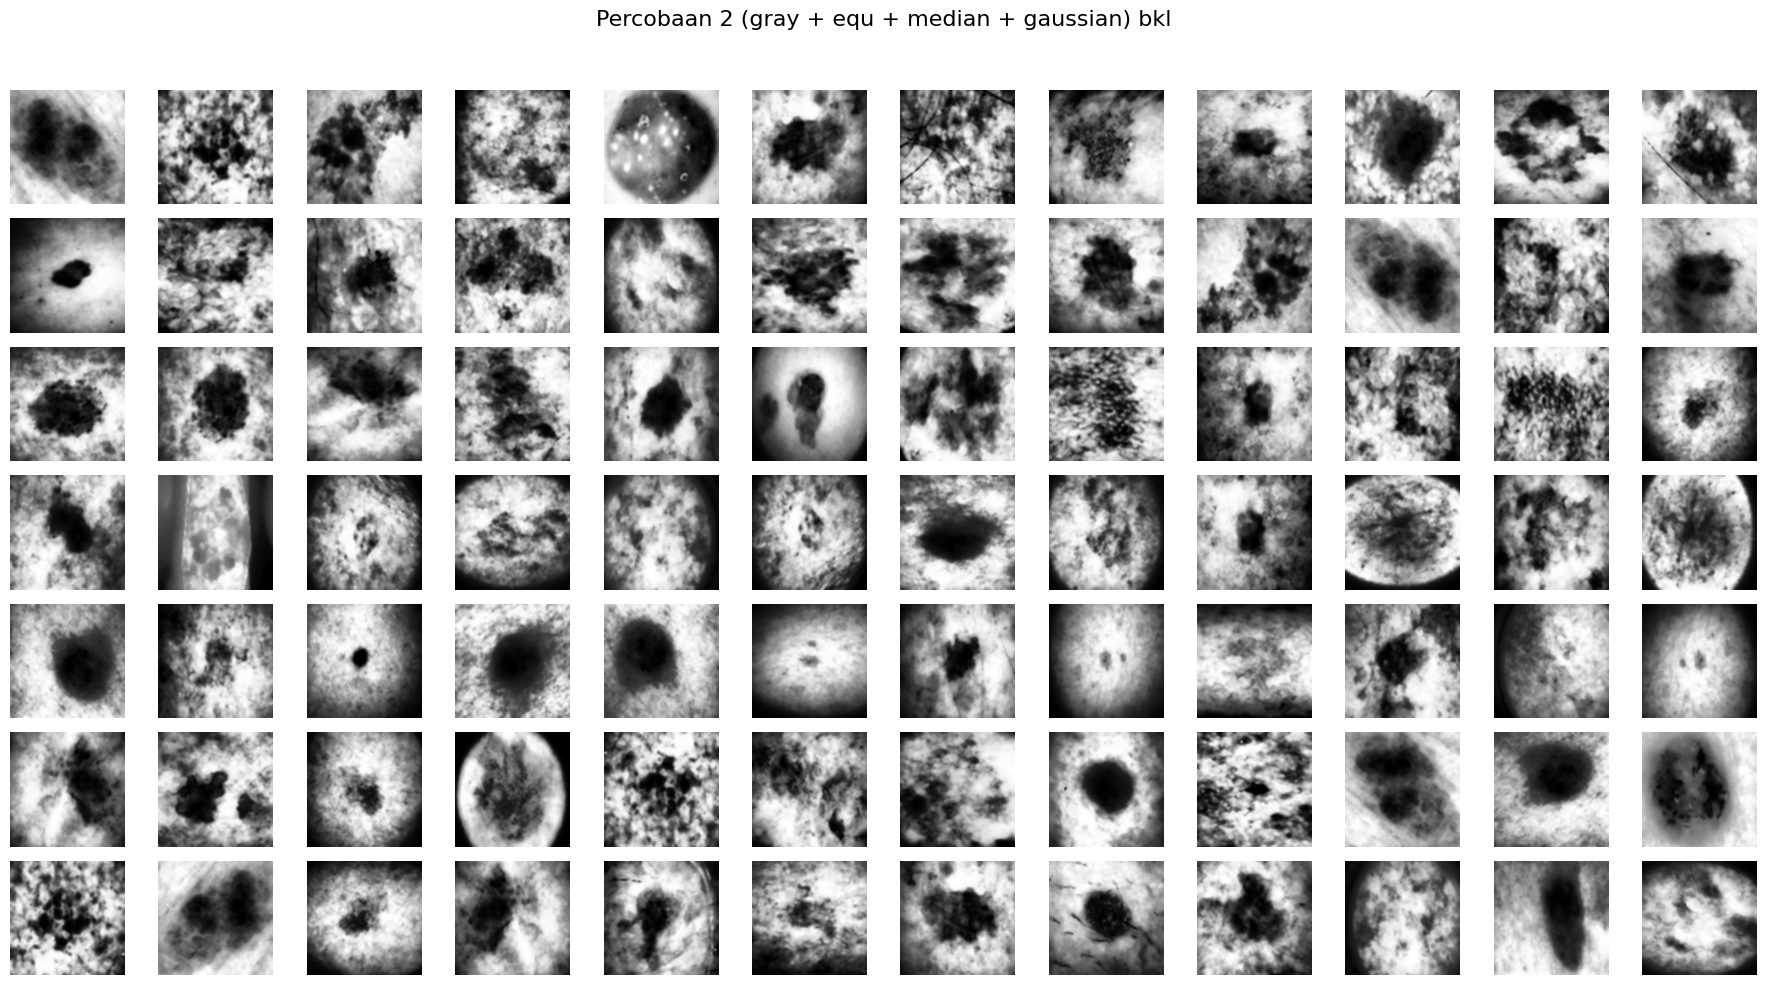

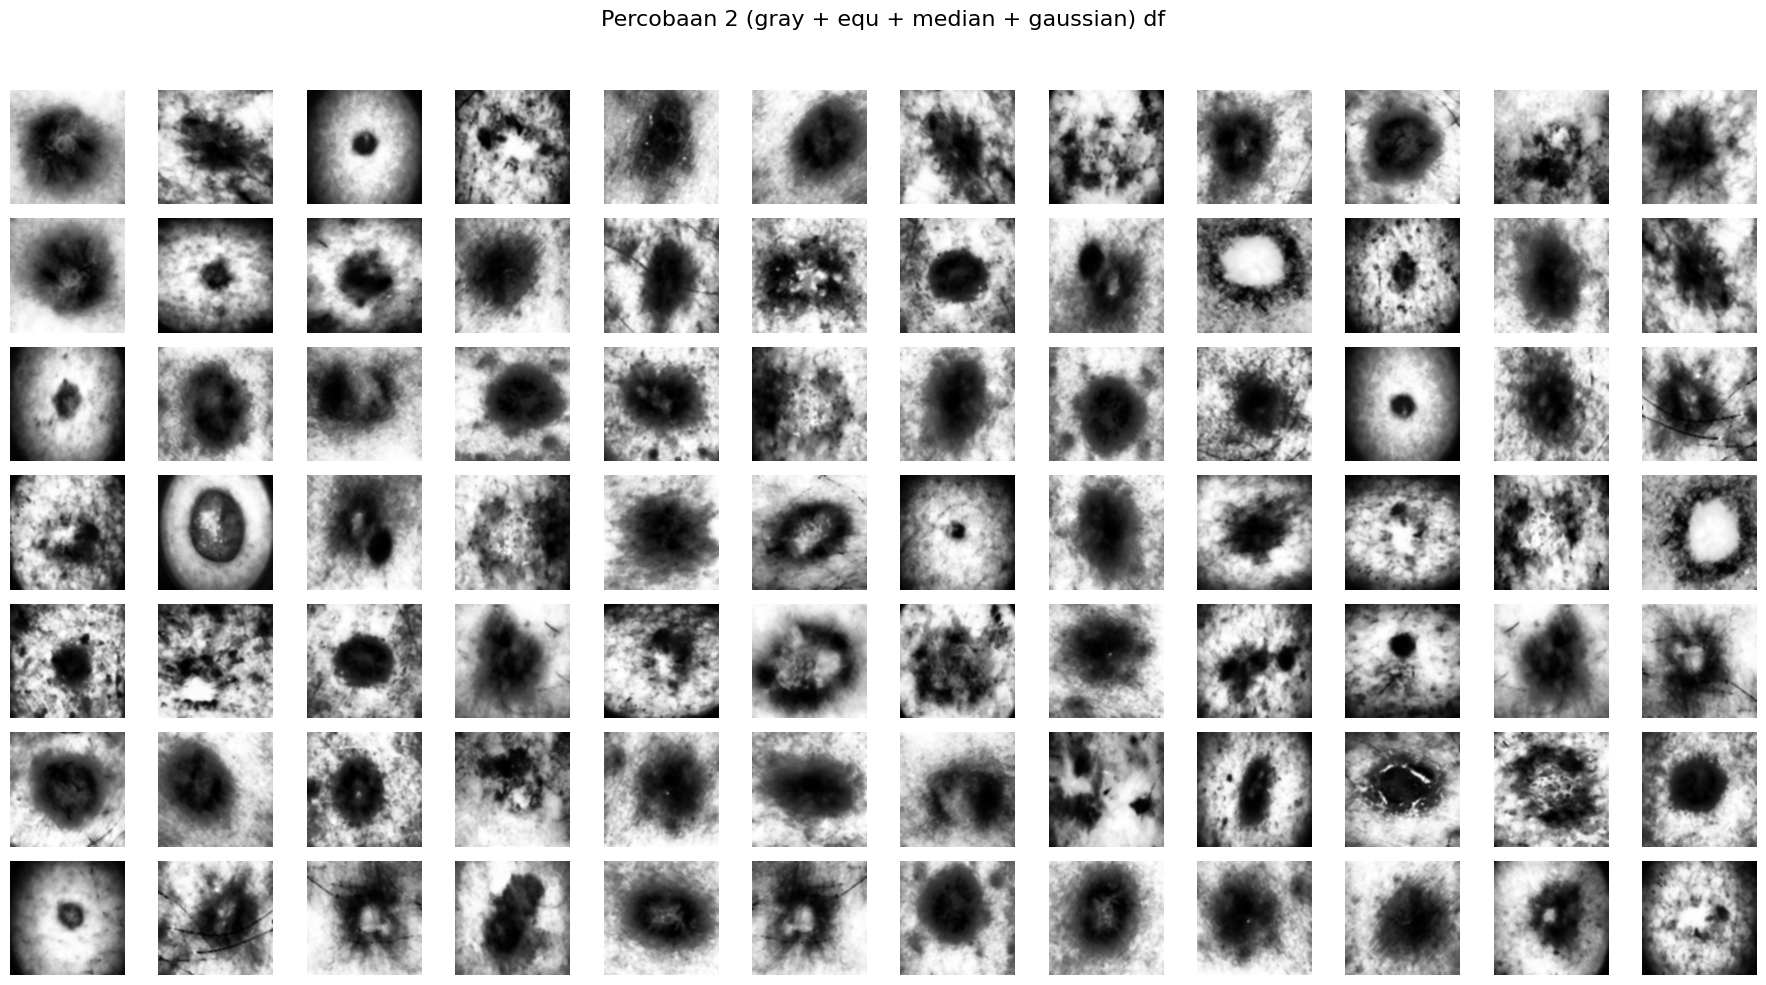

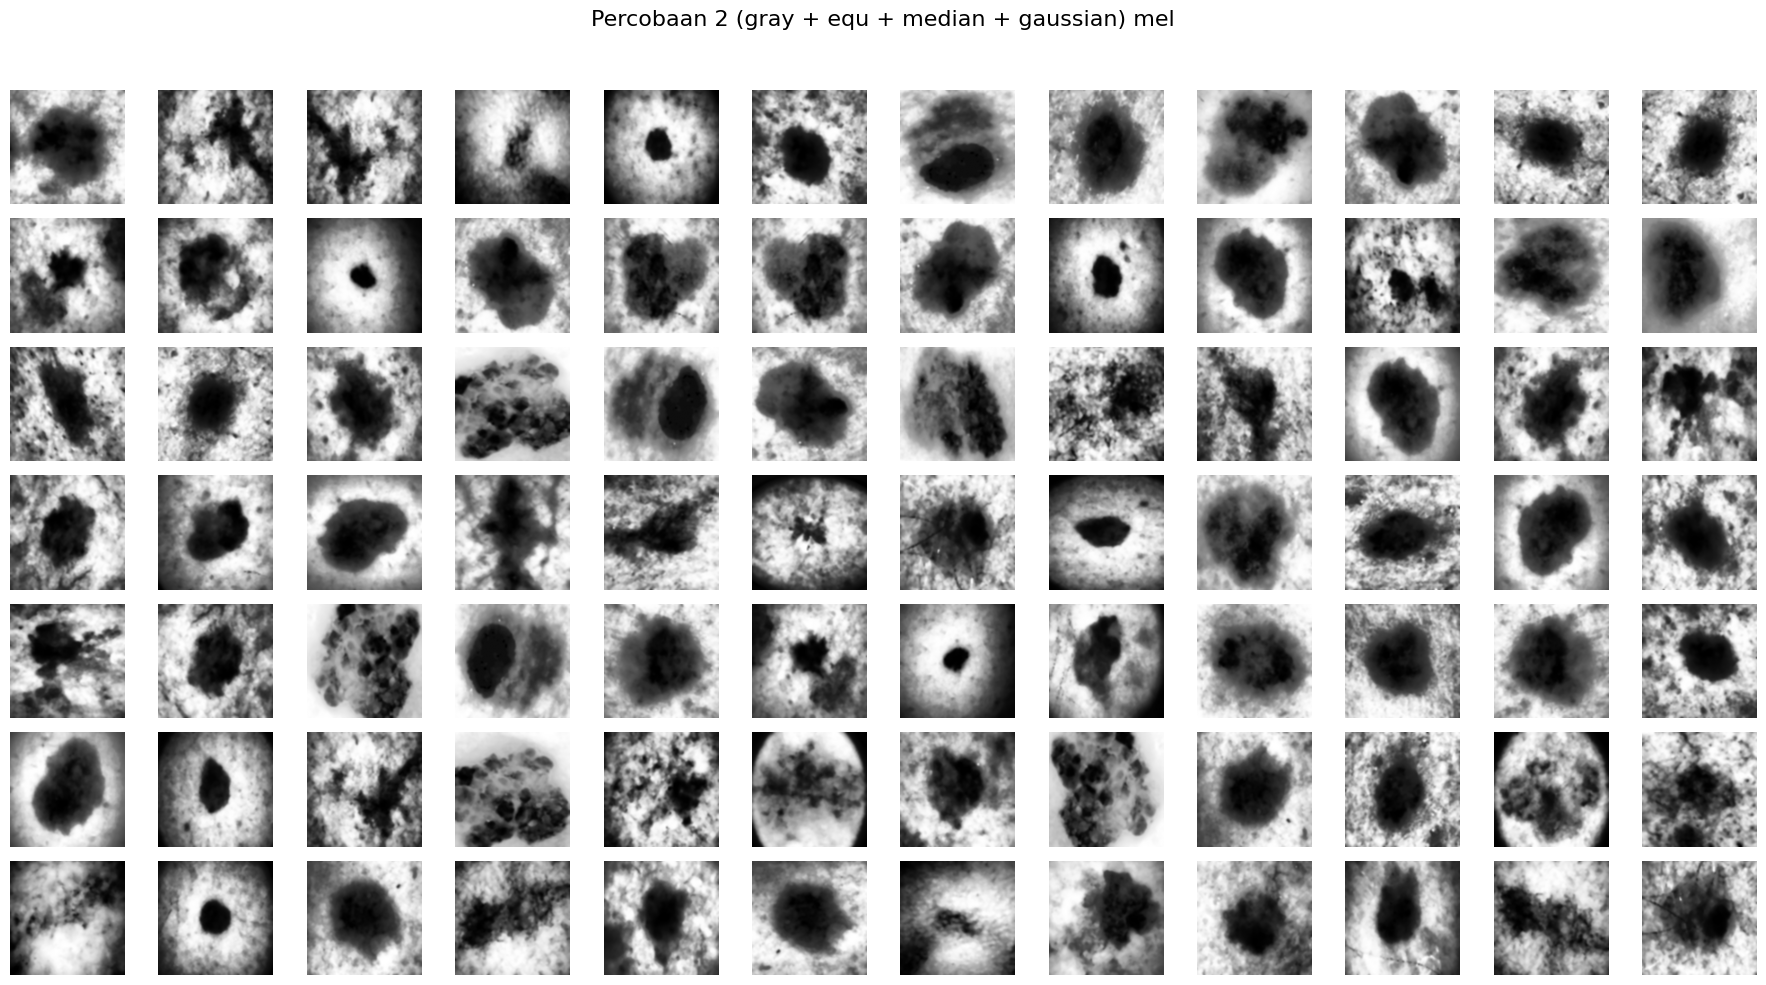

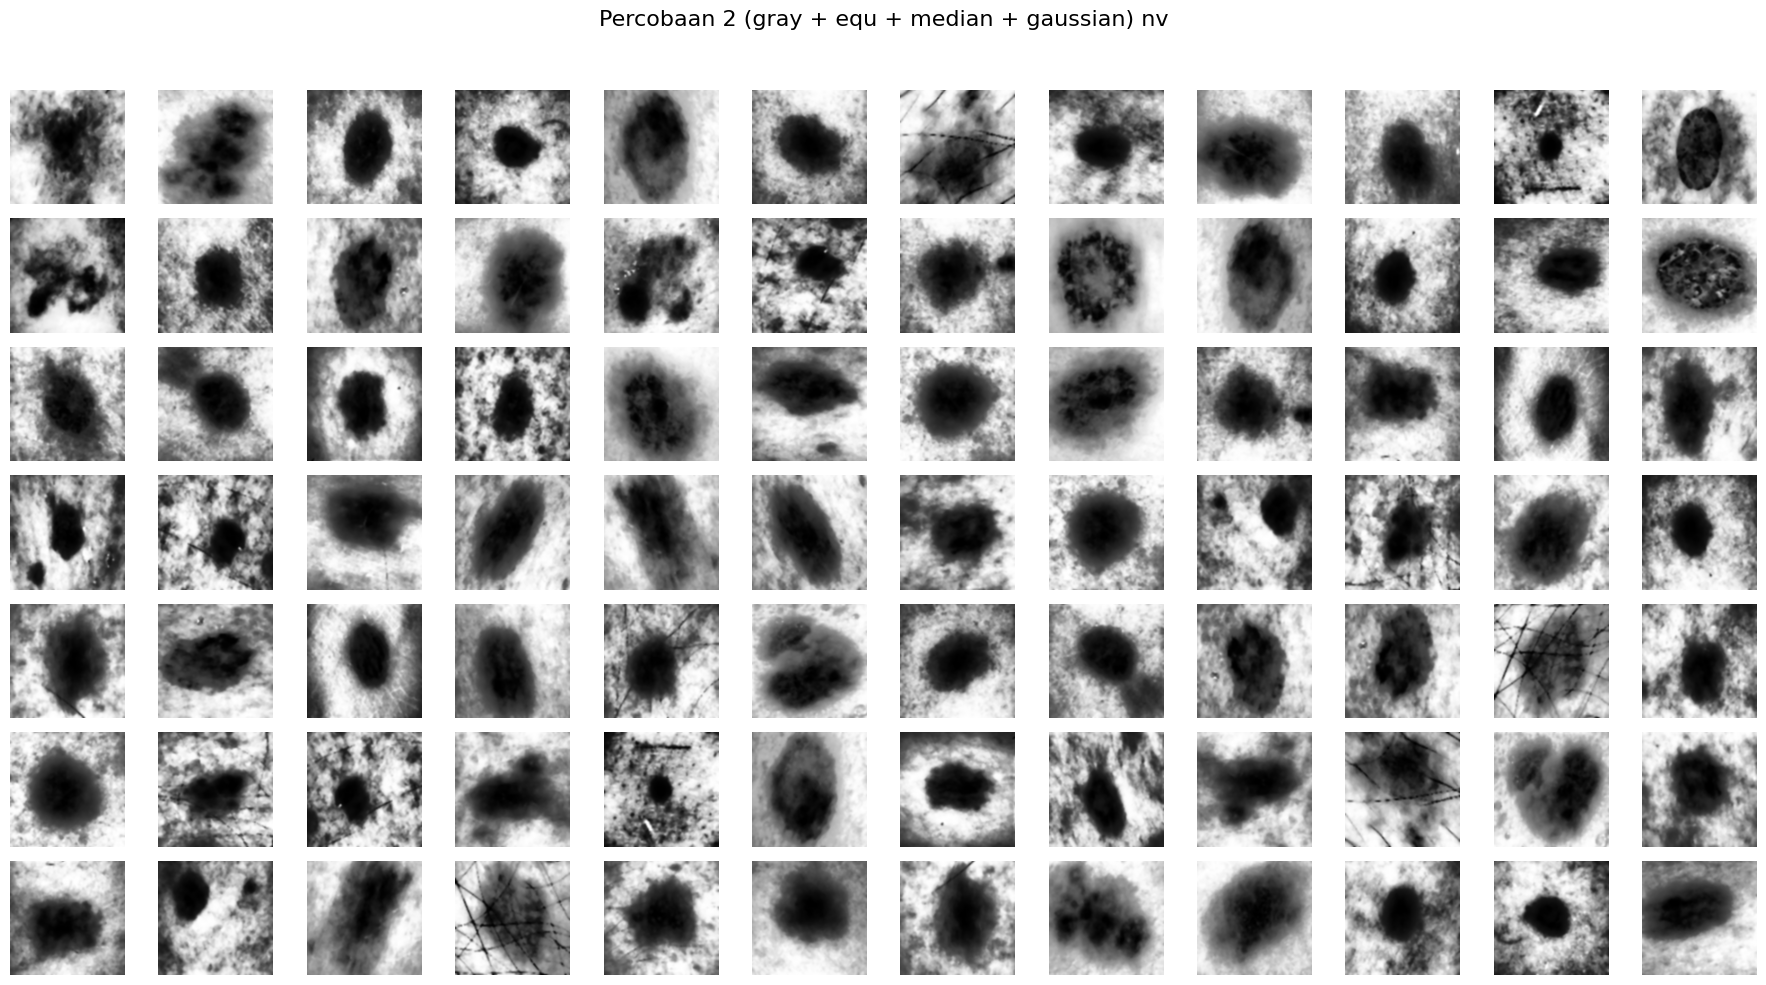

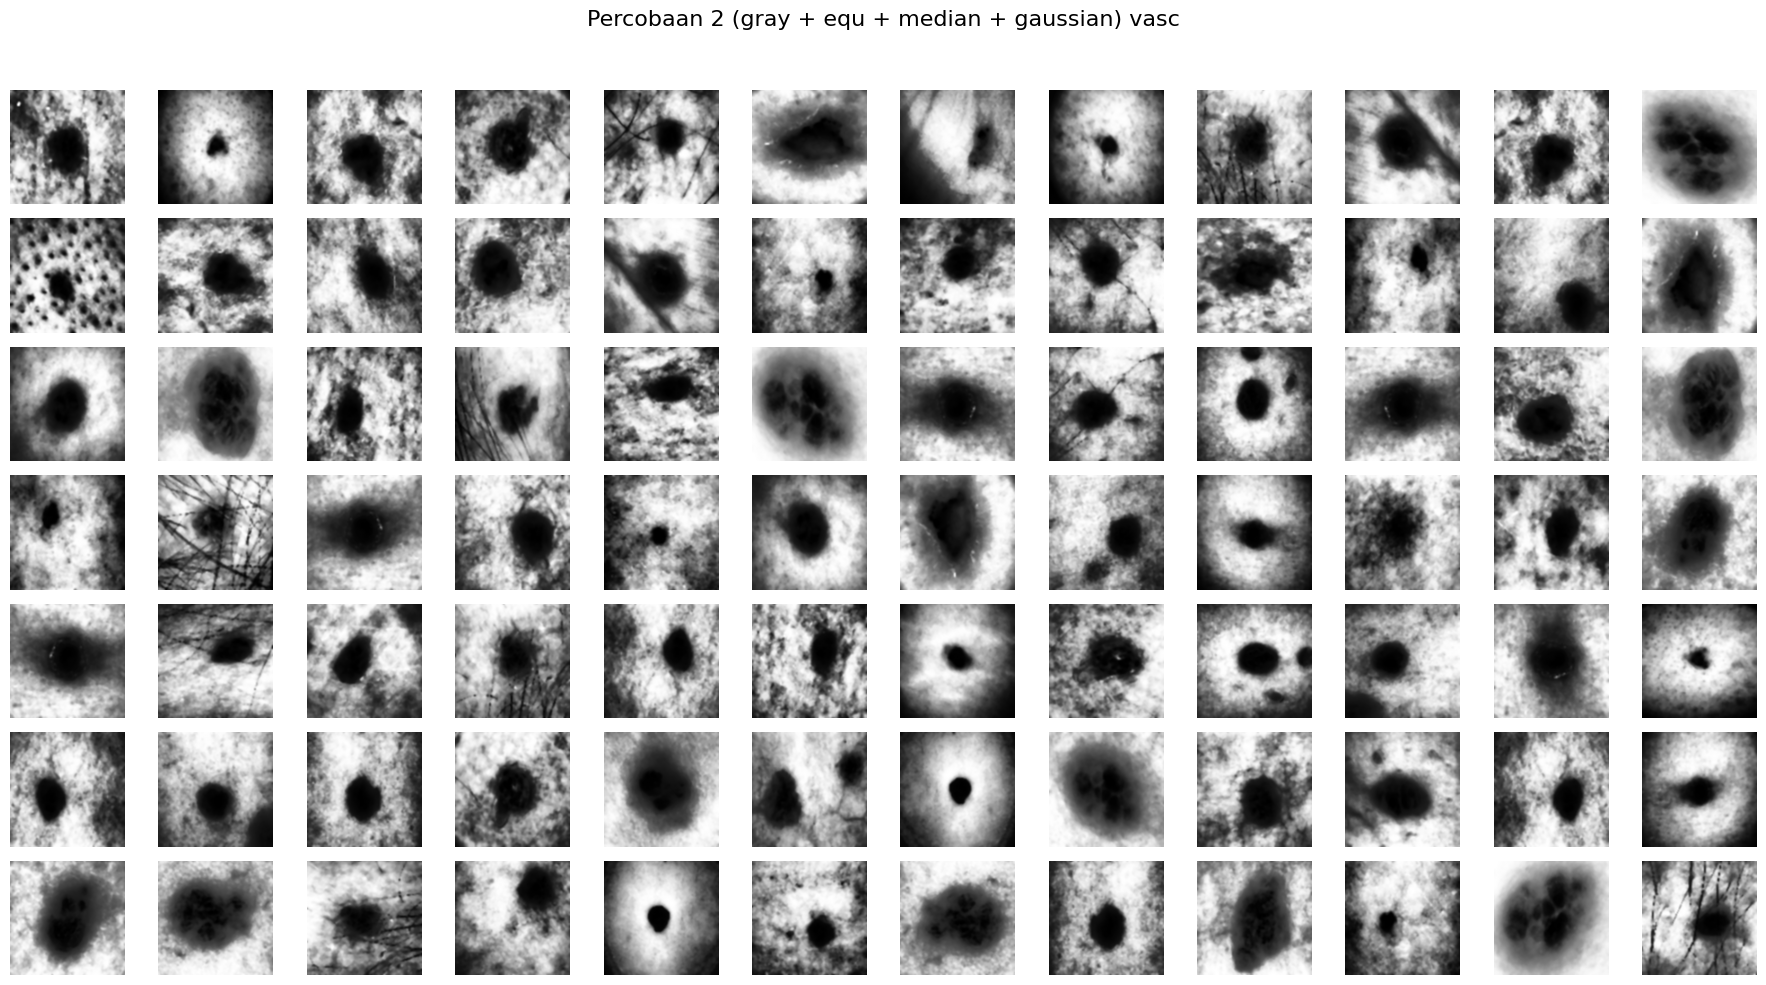

In [ ]:
# Gaussian kernel 3x3
gaussian_kernel = (1/16) * np.array([[1, 2, 1],
                                     [2, 4, 2],
                                     [1, 2, 1]])

def percobaan2(gray):
    img_eq = histogram_equalization(gray)
    img_median = filter_median(img_eq, np.ones((3, 3), dtype=np.uint8))
    img_gaus = filter_image(img_median, gaussian_kernel)
    return img_gaus

dataPreprocessed = [percobaan2(img).astype(np.uint8) for img in data_augmented]

unique_labels = sorted(set(labels_augmented))

for label in unique_labels:
    idxs = [j for j, l in enumerate(labels_augmented) if l == label]
    idxs = np.random.choice(idxs, size=min(84, len(idxs)), replace=False)  # Ambil 84 gambar acak
    n_imgs = len(idxs)
    n_rows, n_cols = 7, 12
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 10))
    fig.suptitle(f'Percobaan 2 (gray + equ + median + gaussian) {label}', fontsize=16)
    
    for k in range(n_rows * n_cols):
        row = k // n_cols
        col = k % n_cols
        ax = axs[row][col]
        if k < n_imgs:
            ax.imshow(dataPreprocessed[idxs[k]], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


## Ekstraksi Fitur

In [18]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    
    return glcm

In [19]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [20]:
# Fungsi ekstraksi fitur untuk list citra
def ekstrak_fitur_glcm(data, nama_prepro):
    fitur_list = []
    for img in data:
        img_u8 = img.astype(np.uint8)
        m = glcm(img_u8, 0)  # derajat 0
        
        fitur = {
            'contrast': contrast(m),
            'correlation': correlation(m),
            'energy': energy(m),
            'homogeneity': homogenity(m),
            'dissimilarity': dissimilarity(m),
            'ASM': ASM(m),
            'entropy': entropyGlcm(m)
        }
        fitur_list.append(fitur)

    df = pd.DataFrame(fitur_list)
    df['tahap'] = nama_prepro
    return df

df2 = ekstrak_fitur_glcm(dataPreprocessed, 'percobaan2')
display(df2)

contrast  correlation    energy  homogeneity  dissimilarity       ASM  \
0     88.535925     0.991699  0.014949     0.170110       6.890256  0.000223   
1     88.535925     0.991699  0.014949     0.170110       6.890256  0.000223   
2     88.535925     0.991699  0.014949     0.170110       6.890256  0.000223   
3     61.217766     0.994280  0.016193     0.204414       5.473671  0.000262   
4     88.535925     0.991699  0.014949     0.170110       6.890256  0.000223   
...         ...          ...       ...          ...            ...       ...   
2445  63.499323     0.994192  0.015787     0.192817       5.631951  0.000249   
2446  63.499323     0.994192  0.015787     0.192817       5.631951  0.000249   
2447  63.499323     0.994192  0.015787     0.192817       5.631951  0.000249   
2448  47.832862     0.995662  0.017340     0.236662       4.789555  0.000301   
2449  63.499323     0.994192  0.015787     0.192817       5.631951  0.000249   

       entropy       tahap  
0     8.785187  percobaan2  
1     8.785187  percobaan2  
2     8.785187  percobaan2  
3     8.599487  percobaan2  
4     8.785187  percobaan2  
...        ...         ...  
2445  8.614071  percobaan2  
2446  8.614071  percobaan2  
2447  8.614071  percobaan2  
2448  8.467270  percobaan2  
2449  8.614071  percobaan2  

[2450 rows x 8 columns]

In [21]:
Derajat0, Derajat45, Derajat90, Derajat135 = [], [], [], []
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 = [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 = [], [], [], []
ASM0, ASM45, ASM90, ASM135 = [], [], [], []
energy0, energy45, energy90, energy135 = [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

for img in dataPreprocessed:
    D0 = glcm(img.astype(np.uint8), 0)
    D45 = glcm(img.astype(np.uint8), 45)
    D90 = glcm(img.astype(np.uint8), 90)
    D135 = glcm(img.astype(np.uint8), 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

    Kontras0.append(contrast(D0))
    Kontras45.append(contrast(D45))
    Kontras90.append(contrast(D90))
    Kontras135.append(contrast(D135))

    dissimilarity0.append(dissimilarity(D0))
    dissimilarity45.append(dissimilarity(D45))
    dissimilarity90.append(dissimilarity(D90))
    dissimilarity135.append(dissimilarity(D135))

    homogenity0.append(homogenity(D0))
    homogenity45.append(homogenity(D45))
    homogenity90.append(homogenity(D90))
    homogenity135.append(homogenity(D135))

    entropy0.append(entropyGlcm(D0))
    entropy45.append(entropyGlcm(D45))
    entropy90.append(entropyGlcm(D90))
    entropy135.append(entropyGlcm(D135))

    ASM0.append(ASM(D0))
    ASM45.append(ASM(D45))
    ASM90.append(ASM(D90))
    ASM135.append(ASM(D135))

    energy0.append(energy(D0))
    energy45.append(energy(D45))
    energy90.append(energy(D90))
    energy135.append(energy(D135))

    correlation0.append(correlation(D0))
    correlation45.append(correlation(D45))
    correlation90.append(correlation(D90))
    correlation135.append(correlation(D135))


## Hasil Ekstraksi to CSV

In [22]:
features = []

for i in range(len(dataPreprocessed)):
    fitur = [
        contrast(Derajat0[i]), contrast(Derajat45[i]), contrast(Derajat90[i]), contrast(Derajat135[i]),
        dissimilarity(Derajat0[i]), dissimilarity(Derajat45[i]), dissimilarity(Derajat90[i]), dissimilarity(Derajat135[i]),
        homogenity(Derajat0[i]), homogenity(Derajat45[i]), homogenity(Derajat90[i]), homogenity(Derajat135[i]),
        entropyGlcm(Derajat0[i]), entropyGlcm(Derajat45[i]), entropyGlcm(Derajat90[i]), entropyGlcm(Derajat135[i]),
        ASM(Derajat0[i]), ASM(Derajat45[i]), ASM(Derajat90[i]), ASM(Derajat135[i]),
        energy(Derajat0[i]), energy(Derajat45[i]), energy(Derajat90[i]), energy(Derajat135[i]),
        correlation(Derajat0[i]), correlation(Derajat45[i]), correlation(Derajat90[i]), correlation(Derajat135[i]),
    ]
    features.append(fitur)

# Buat dataframe
columns = [
    "contrast_0", "contrast_45", "contrast_90", "contrast_135",
    "dissimilarity_0", "dissimilarity_45", "dissimilarity_90", "dissimilarity_135",
    "homogeneity_0", "homogeneity_45", "homogeneity_90", "homogeneity_135",
    "entropy_0", "entropy_45", "entropy_90", "entropy_135",
    "ASM_0", "ASM_45", "ASM_90", "ASM_135",
    "energy_0", "energy_45", "energy_90", "energy_135",
    "correlation_0", "correlation_45", "correlation_90", "correlation_135"
]

df_fitur = pd.DataFrame(features, columns=columns)


In [23]:
dataTable = {
        'Filename': file_name_augmented, 'Label': labels_augmented,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
}
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_percobaan2.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_percobaan2.csv')
hasilEkstrak


Filename  Label  Contrast0  Contrast45  Contrast90  Contrast135  \
0     ISIC_0024329.jpg  akiec  88.535925  158.163866   61.217766   132.764152   
1     ISIC_0024329.jpg  akiec  88.535925  132.764152   61.217766   158.163866   
2     ISIC_0024329.jpg  akiec  88.535925  132.764152   61.217766   158.163866   
3     ISIC_0024329.jpg  akiec  61.217766  132.764152   88.535925   158.163866   
4     ISIC_0024329.jpg  akiec  88.535925  158.163866   61.217766   132.764152   
...                ...    ...        ...         ...         ...          ...   
2445  ISIC_0029514.jpg   vasc  63.499323  105.269391   47.832862   109.525699   
2446  ISIC_0029514.jpg   vasc  63.499323  109.525699   47.832862   105.269391   
2447  ISIC_0029514.jpg   vasc  63.499323  109.525699   47.832862   105.269391   
2448  ISIC_0029514.jpg   vasc  47.832862  109.525699   63.499323   105.269391   
2449  ISIC_0029514.jpg   vasc  63.499323  105.269391   47.832862   109.525699   

      Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  ...  \
0         0.170110       0.138422       0.204414        0.148086  ...   
1         0.170110       0.148086       0.204414        0.138422  ...   
2         0.170110       0.148086       0.204414        0.138422  ...   
3         0.204414       0.148086       0.170110        0.138422  ...   
4         0.170110       0.138422       0.204414        0.148086  ...   
...            ...            ...            ...             ...  ...   
2445      0.192817       0.169800       0.236662        0.152388  ...   
2446      0.192817       0.152388       0.236662        0.169800  ...   
2447      0.192817       0.152388       0.236662        0.169800  ...   
2448      0.236662       0.152388       0.192817        0.169800  ...   
2449      0.192817       0.169800       0.236662        0.152388  ...   

         ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0     0.000262  0.000190  0.014949  0.013298  0.016193   0.013766   
1     0.000262  0.000177  0.014949  0.013766  0.016193   0.013298   
2     0.000262  0.000177  0.014949  0.013766  0.016193   0.013298   
3     0.000223  0.000177  0.016193  0.013766  0.014949   0.013298   
4     0.000262  0.000190  0.014949  0.013298  0.016193   0.013766   
...        ...       ...       ...       ...       ...        ...   
2445  0.000301  0.000199  0.015787  0.014430  0.017340   0.014094   
2446  0.000301  0.000208  0.015787  0.014094  0.017340   0.014430   
2447  0.000301  0.000208  0.015787  0.014094  0.017340   0.014430   
2448  0.000249  0.000208  0.017340  0.014094  0.015787   0.014430   
2449  0.000301  0.000199  0.015787  0.014430  0.017340   0.014094   

      Correlation0  Correlation45  Correlation90  Correlation135  
0         0.991699       0.985168       0.994280        0.987549  
1         0.991699       0.987549       0.994280        0.985168  
2         0.991699       0.987549       0.994280        0.985168  
3         0.994280       0.987549       0.991699        0.985168  
4         0.991699       0.985168       0.994280        0.987549  
...            ...            ...            ...             ...  
2445      0.994192       0.990360       0.995662        0.989970  
2446      0.994192       0.989970       0.995662        0.990360  
2447      0.994192       0.989970       0.995662        0.990360  
2448      0.995662       0.989970       0.994192        0.990360  
2449      0.994192       0.990360       0.995662        0.989970  

[2450 rows x 30 columns]

## Feature Selection

### Correlation

<Axes: >

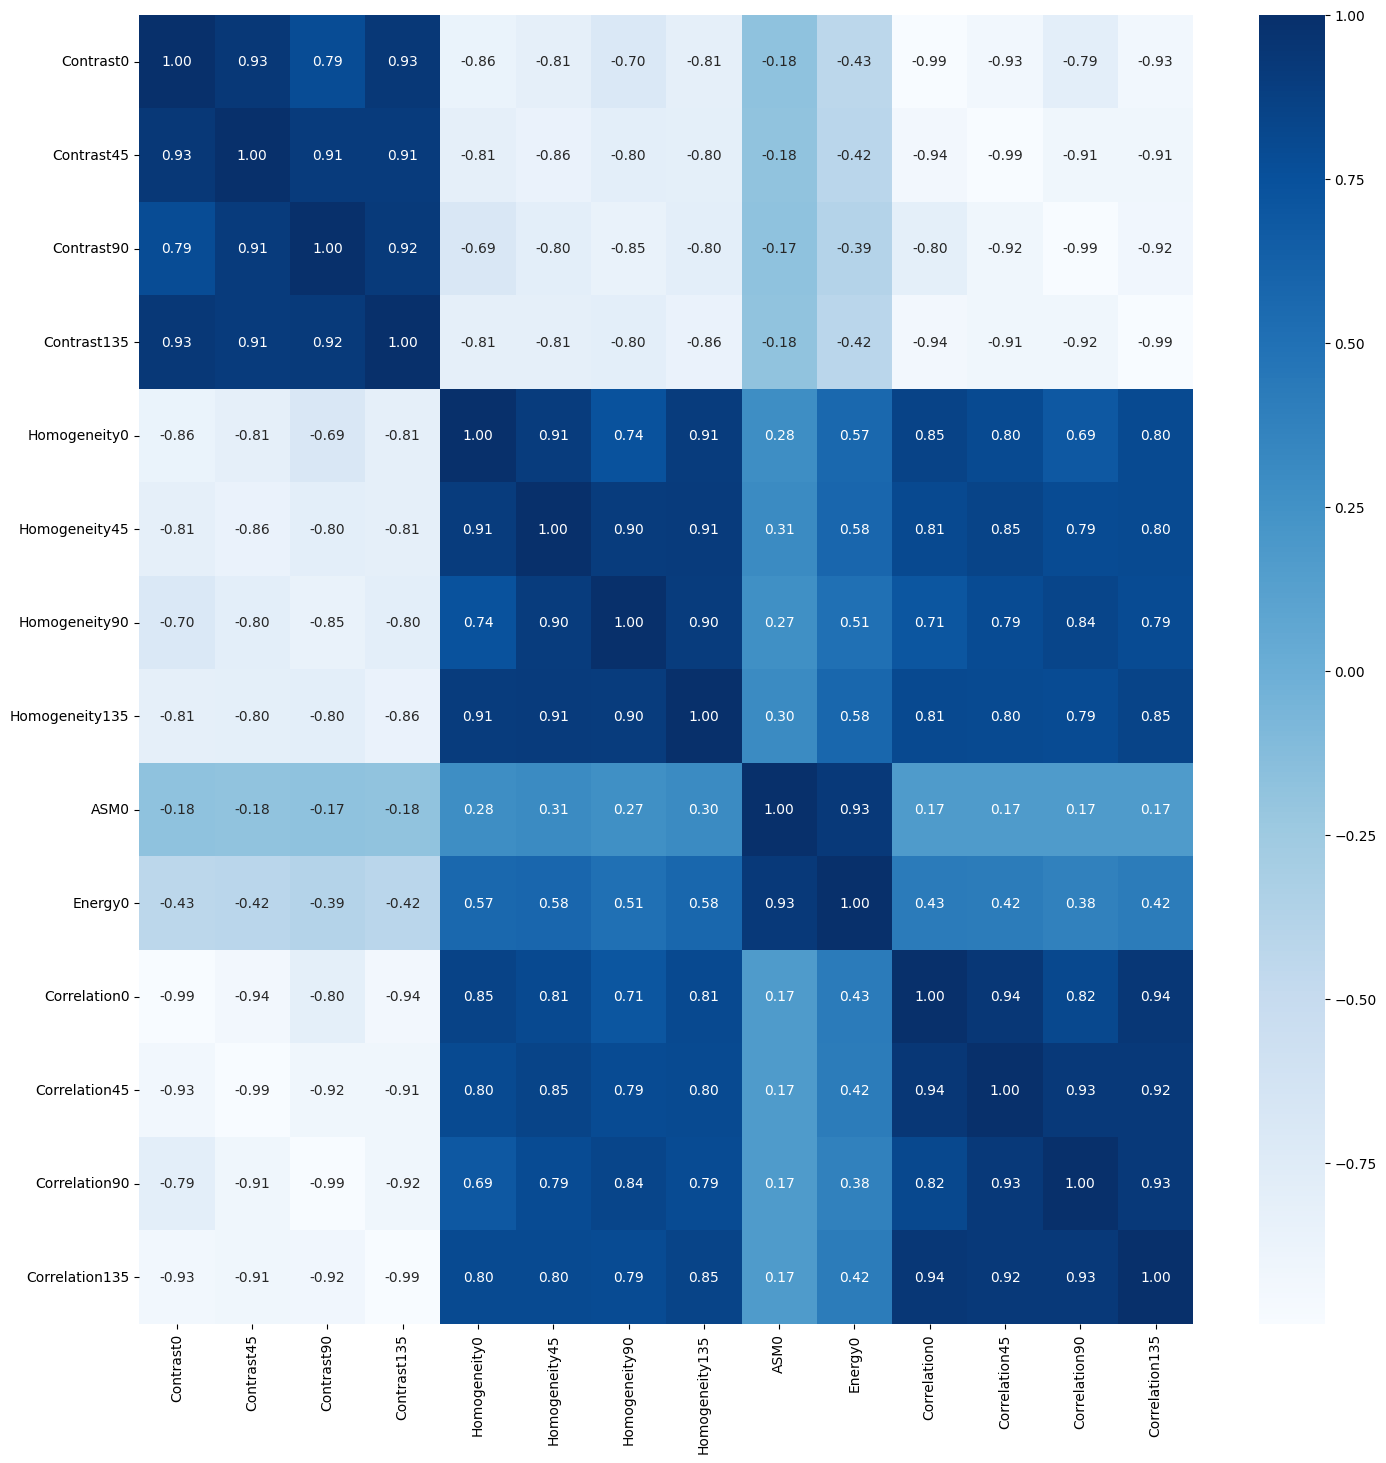

In [24]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [25]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1960, 14)
(490, 14)
(1960,)
(490,)


## Feature Normalization

In [26]:
# normalisasi mean std (Standardization / Z-score normalization)
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [27]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [28]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       akiec       0.98      0.99      0.98       282
         bcc       0.97      0.98      0.97       271
         bkl       0.98      0.97      0.98       279
          df       0.99      0.99      0.99       285
         mel       0.99      0.99      0.99       284
          nv       0.99      0.99      0.99       269
        vasc       0.99      0.98      0.99       290

    accuracy                           0.98      1960
   macro avg       0.98      0.98      0.98      1960
weighted avg       0.98      0.98      0.98      1960

[[278   0   1   0   2   1   0]
 [  1 266   2   0   1   0   1]
 [  2   2 272   1   1   0   1]
 [  1   1   0 282   0   0   1]
 [  1   2   1   0 280   0   0]
 [  0   2   1   0   0 266   0]
 [  1   2   0   1   0   1 285]]
Accuracy: 0.9841836734693877

------Testing Set------
              precision    recall  f1-score   support

       akiec       0.70      0.76      0.73        

### Train SVM Classifier

In [29]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       akiec       0.25      0.68      0.36       282
         bcc       0.47      0.15      0.22       271
         bkl       0.31      0.10      0.15       279
          df       0.35      0.35      0.35       285
         mel       0.32      0.43      0.37       284
          nv       0.41      0.32      0.36       269
        vasc       0.48      0.20      0.28       290

    accuracy                           0.32      1960
   macro avg       0.37      0.32      0.30      1960
weighted avg       0.37      0.32      0.30      1960

[[193  14  13  26  33   2   1]
 [135  40  13  41  17  13  12]
 [126   7  28  28  49  22  19]
 [128   4   0 101  27  21   4]
 [ 79   3   6  29 123  26  18]
 [ 39   9  11  37  78  87   8]
 [ 86   9  18  23  53  43  58]]
Accuracy: 0.32142857142857145

------Testing Set------
              precision    recall  f1-score   support

       akiec       0.23      0.66      0.34      

### Train KNN Classifier

In [30]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

       akiec       0.60      0.79      0.68       282
         bcc       0.68      0.74      0.71       271
         bkl       0.71      0.72      0.72       279
          df       0.71      0.76      0.74       285
         mel       0.69      0.65      0.67       284
          nv       0.72      0.62      0.66       269
        vasc       0.78      0.54      0.64       290

    accuracy                           0.69      1960
   macro avg       0.70      0.69      0.69      1960
weighted avg       0.70      0.69      0.69      1960

[[222   4  10  11  23   7   5]
 [ 37 200  10   4  11   3   6]
 [ 24  18 202   4  10   9  12]
 [ 29  14   8 218   8   4   4]
 [ 25  12  16  25 186   9  11]
 [ 16  22  19  22  17 166   7]
 [ 18  25  19  23  14  33 158]]
Accuracy: 0.689795918367347

------Testing Set------
              precision    recall  f1-score   support

       akiec       0.39      0.57      0.46        

## Evaluasi Dengan Confussion Matrix

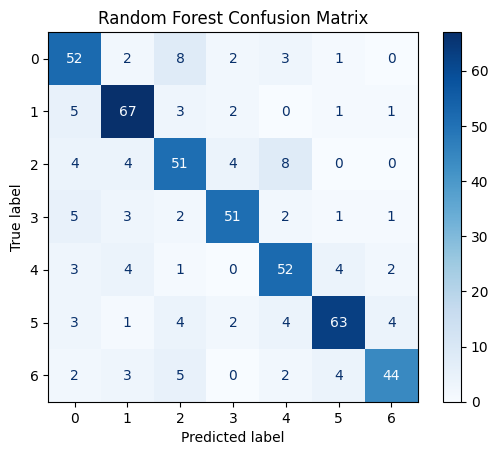

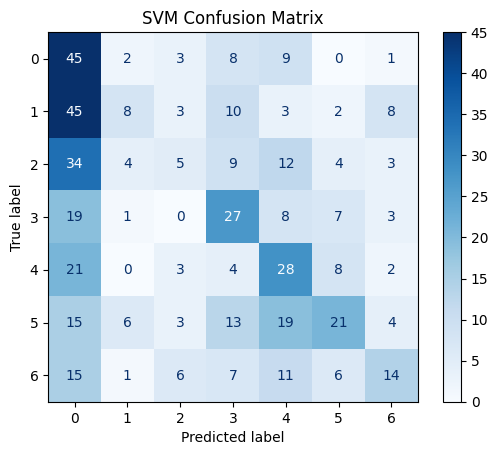

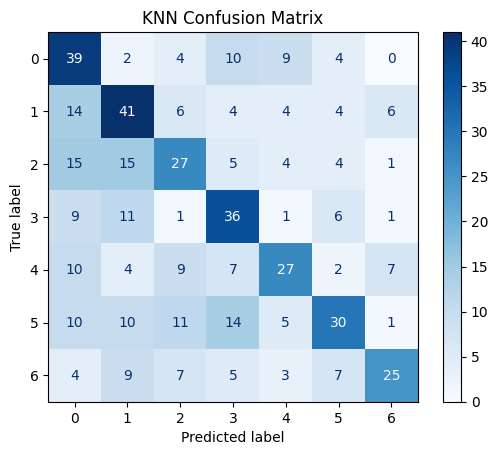

In [31]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")